In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Conv2D, Input, Conv2DTranspose, MaxPooling2D, concatenate, BatchNormalization, Activation, Add, Dropout, DepthwiseConv2D, Flatten, Dense
from skimage.transform import resize
from sklearn.model_selection import train_test_split

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

from tensorflow import keras
import tensorflow.keras.backend as K
import gc
from tensorflow.keras import optimizers
from tqdm.notebook import tqdm_notebook

from tensorflow.keras.utils import to_categorical
import seaborn as sns

from tensorflow.keras.callbacks import ModelCheckpoint,  CSVLogger, EarlyStopping, ReduceLROnPlateau


print("Imports done")

Imports done


In [2]:
tf.__version__

'2.4.1'

#### Callbacks

In [3]:
savePath="./Test_1_checkpoints/saved-{epoch:02d}-{val_my_iou_metric:.2f}.hdf5"

checkPoint = ModelCheckpoint(savePath, monitor='val_my_iou_metric', verbose=1, save_best_only= True, mode='max')
early_stop = EarlyStopping(monitor='val_my_iou_metric', patience=15, verbose=1, mode='max')
reduce_lr_OnPlateau = ReduceLROnPlateau(factor=0.75,monitor='val_my_iou_metric', mode='max', patience=5, min_lr=0.0001, verbose=1)

#CSVLogger logs epoch, acc, loss, val_acc, val_loss
log_csv = CSVLogger('my_logs.csv', separator=',', append=False)
callbacks_list = [early_stop, checkPoint, reduce_lr_OnPlateau]

#### Loading the data 
For faster development, we have fixed a validation dataset. For sanity checks and debuging we have the option to load just the first "rows" from the dataset.

In [4]:
# ------------------------------------------------------------------------------- #
#                              Important Variables                                #
# ------------------------------------------------------------------------------- #
np.random.seed(42)
data_dir = "../../DL_data/competition_data"
validation_data_dir = "../../DL_data/competition_data"
nrows = "all"                # Set to 'all' to load the whole set
load_validation = False      # Only load the validation images and masks??
split_train_test = True      # Split data to train and test sets??
data_augmentation = True     # Augment the data??
# ------------------------------------------------------------------------------- #


# load the ids  and depths of 'nrows' from the training data set
if isinstance(nrows, int) and nrows > 0:
    train_df = pd.read_csv(data_dir + "/train.csv", index_col="id", usecols=[0], nrows=nrows)
    depths_df = pd.read_csv(data_dir + "/depths.csv", index_col="id")
    train_df = train_df.join(depths_df)
    test_df = depths_df[~depths_df.index.isin(train_df.index)]
elif isinstance(nrows, str) and nrows.upper() == "ALL":
    train_df = pd.read_csv(data_dir + "/train.csv", index_col="id", usecols=[0])
    depths_df = pd.read_csv(data_dir + "/depths.csv", index_col="id")
    train_df = train_df.join(depths_df)
    test_df = depths_df[~depths_df.index.isin(train_df.index)]
else:
    raise ValueError("Invalid nrows value")


# Function that loads the ids of 'nrows' from the validation data set
def load_validation_data(data_dir, nrows):
    if isinstance(nrows, int) and nrows > 0:
        valid_ids = pd.read_csv(data_dir + "/Validation_ids.csv", usecols=[1], nrows=nrows)
    elif isinstance(nrows, str) and nrows.upper() == "ALL":
        valid_ids = pd.read_csv(data_dir + "/Validation_ids.csv")
    else:
        raise ValueError("Invalid nrows value")
    return valid_ids.ids

if load_validation:
    ids_to_load = load_validation_data(data_dir, nrows)
    index_list = list(train_df.index)
    ids_list = [index_list.index(i) for i in ids_to_load]
    train_df = train_df.iloc[ids_list]
else:
    ids_to_load = train_df.index
    
    

print("Loading images...")
train_df["images"] = [np.array(load_img(data_dir + "/train/images/{}.png".format(idx),
                                        color_mode="grayscale")) / 255 for idx in tqdm_notebook(list(ids_to_load))]
print("Loading masks...")
train_df["masks"] = [np.array(load_img(data_dir + "/train/masks/{}.png".format(idx),
                                       color_mode="grayscale")) / 65535 for idx in tqdm_notebook(list(ids_to_load))]

print("done loading images")

Loading images...


  0%|          | 0/4000 [00:00<?, ?it/s]

Loading masks...


  0%|          | 0/4000 [00:00<?, ?it/s]

done loading images


### Print an example of the data

-------------------------------------------------------------
id_index =  342
[[0.53333333 0.53333333 0.52941176 ... 0.52156863 0.55294118 0.60392157]
 [0.55294118 0.54901961 0.54509804 ... 0.50196078 0.51372549 0.54117647]
 [0.57254902 0.56862745 0.56470588 ... 0.44313725 0.43921569 0.43529412]
 ...
 [0.49019608 0.4745098  0.47058824 ... 0.56862745 0.56470588 0.56078431]
 [0.48235294 0.4627451  0.44313725 ... 0.56470588 0.56078431 0.55294118]
 [0.47058824 0.45098039 0.43137255 ... 0.56078431 0.55294118 0.54117647]]
(101, 101)
-------------------------------------------------------------
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(101, 101)


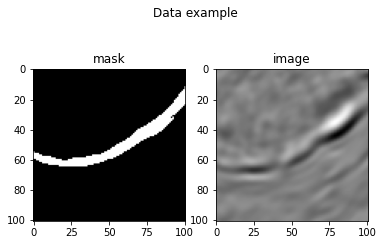

In [5]:
# printing
print("-------------------------------------------------------------")
id = '7d5c34a95a'
id_index = np.where(train_df.index == id)
id_index = id_index[0][0]
print("id_index = ", id_index)
image = train_df["images"][id]
print(image)
print(image.shape)
print("-------------------------------------------------------------")
mask = train_df["masks"][id]
print(mask)
print(mask.shape)

def plot_image_example():
    fig_imgshow, (axs_mask, axs_img) = plt.subplots(1, 2)
    fig_imgshow.suptitle("Data example")
    axs_img.imshow(np.dstack((image, image, image)))  # interpolation='nearest'
    axs_img.set(title="image")
    tmp = np.squeeze(mask).astype(np.float32)
    axs_mask.imshow(np.dstack((tmp, tmp, tmp)))
    axs_mask.set(title="mask")


plot_image_example()

### Preprossessing the Data

#### Resizeing the images

In [6]:
# either pad with zeros or resize with interpolation
resize_to = 128
original_size = 101


def upsample(original_img):
    if resize_to == original_size:
        return original_img
    return resize(original_img, (resize_to, resize_to), mode='constant', preserve_range=True)


def pad_zeros(array):
    padded_image = np.zeros(shape=(resize_to, resize_to))
    padded_image[13:114, 13:114] = array
    return padded_image


resizing_function_to_use = pad_zeros

images_resized = np.array(train_df.images.map(resizing_function_to_use).tolist()).reshape((-1, resize_to, resize_to, 1))
masks_resized = np.array(train_df.masks.map(resizing_function_to_use).tolist()).reshape((-1, resize_to, resize_to, 1))

### Spliting to train/ validation/ test

#### Calculate the salt coverage for each immage

Text(0.5, 0, 'Coverage class')

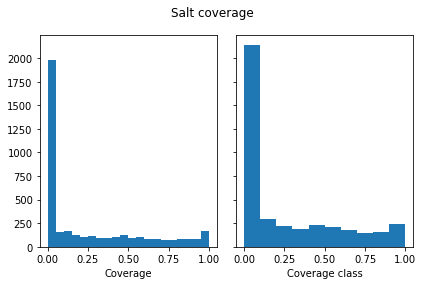

In [7]:
# calculate salt coverage
train_df["coverage"] = train_df.masks.map(np.sum) / (101*101)


# Generate salt coverage classes
def cov_to_class(val):
    for i in range(0, 11):
        if val * 10 <= i:
            return i

#map salt coverage to salt coverage class
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)


# Plotting the salt coverage classes
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
n_bins = 20
axs[0].hist(train_df.coverage, bins=n_bins)
axs[1].hist(train_df.coverage, bins=10)

plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

#### Take a test set using stratified sampling based on the salt coverage.
Sample uniformly for each salt coverage class

In [8]:
if split_train_test:
    (ids_trainAndValid, ids_test, x_trainAndValid, x_test, y_trainAndValid, y_test) = train_test_split(
                                                                      train_df.index.values,
                                                                      images_resized, masks_resized,
                                                                      test_size=500,
                                                                      stratify=train_df.coverage_class,
                                                                      random_state=1337)
else: # for the case that we only load a validation test or for debuging
    x_trainAndValid = images_resized
    y_trainAndValid = masks_resized
    ids_trainAndValid = train_df.index.values
    x_test = np.array([])  # Just to print the x_valid.shape([0]) in the end
    y_test = np.array([])


print("Train/ Test shape = %d/ %d" % (y_trainAndValid.shape[0], y_test.shape[0]))

Train/ Test shape = 3500/ 500


##### Recompute the coverage class of the remaining training set 
We fo that to take an additional validation set from the training set, again stratified based on the salt coverage class.

Text(0.5, 0, 'Coverage class')

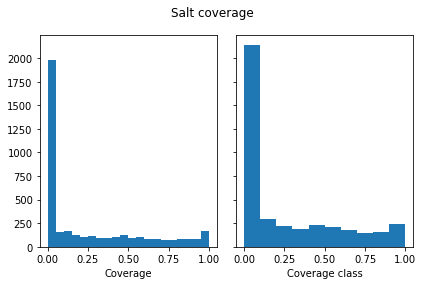

In [9]:
# Create a temp data frame to use for spliting training and validation
train_temp_df=pd.DataFrame(data={"images": list(x_trainAndValid), "masks":list(y_trainAndValid)}, index=list(ids_trainAndValid))

train_temp_df["coverage"] = train_temp_df.masks.map(np.sum) / (101*101)

train_temp_df["coverage_class"] = train_temp_df.coverage.map(cov_to_class)

# plotting the re-computed coverage class of the remaining training set
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
n_bins = 20
axs[0].hist(train_df.coverage, bins=n_bins)
axs[1].hist(train_df.coverage, bins=10)

plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

In [10]:
temp_images = np.array(train_temp_df.images.tolist()).reshape((-1, resize_to, resize_to, 1))
temp_masks =  np.array(train_temp_df.masks.tolist()).reshape((-1, resize_to, resize_to, 1))

In [11]:
if split_train_test:
    (x_train, x_valid, y_train, y_valid) = train_test_split(temp_images, temp_masks, 
                                                            test_size=300,
                                                            stratify=train_temp_df["coverage_class"],
                                                            random_state=1337)
else:
    x_train = temp_images
    y_train = temp_masks
    x_valid = np.array([])  # Just to print the x_valid.shape([0]) in the end
    y_valid = np.array([])


print("Train/ Valid/ Test split = %d/ %d/ %d" % (x_train.shape[0], x_valid.shape[0], x_test.shape[0]))

Train/ Valid/ Test split = 3200/ 300/ 500


In [12]:
# cleaning up
del x_trainAndValid
del y_trainAndValid
del temp_images
del temp_masks
gc.collect()

4987

### Data augmentation
##### Fliping the images from left to right and from up to down.

In [13]:
# We use the copies to avoid fliping up and down images that have been fliped left to right
x_train_temp = np.copy(x_train)
y_train_temp = np.copy(y_train)

if data_augmentation:
    print("fliping left/right")
    x_train = np.append(x_train, [np.fliplr(x) for x in (x_train_temp)], axis=0)
    y_train = np.append(y_train, [np.fliplr(x) for x in (y_train_temp)], axis=0)
    
    print("fliping up/down")
    x_train = np.append(x_train, [np.flipud(x) for x in (x_train_temp)], axis=0)
    y_train = np.append(y_train, [np.flipud(x) for x in (y_train_temp)], axis=0)
    
del x_train_temp
del y_train_temp
gc.collect()

print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)

fliping left/right
fliping up/down
x_train shape:  (9600, 128, 128, 1)
y_train shape:  (9600, 128, 128, 1)


#### Creating 3 chanels in the input images

In [14]:
x_train = np.repeat(x_train, 3, axis=3)
x_test = np.repeat(x_test, 3, axis=3)
x_valid = np.repeat(x_valid, 3, axis=3)

In [15]:
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_valid shape: ", x_valid.shape)
print("y_valid shape: ", y_valid.shape)
print("x_test shape: ", x_test.shape)
print("y_test shape: ", y_test.shape)

x_train shape:  (9600, 128, 128, 3)
y_train shape:  (9600, 128, 128, 1)
x_valid shape:  (300, 128, 128, 3)
y_valid shape:  (300, 128, 128, 1)
x_test shape:  (500, 128, 128, 3)
y_test shape:  (500, 128, 128, 1)


# Model

#### IoU competition metric

In [16]:
#Taken from: https://www.kaggle.com/iezepov/fast-iou-scoring-metric-in-pytorch-and-numpy

def get_iou_vector(A, B):
    # Numpy version
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):

        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)

        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue

        # non empty mask case.  Union is never empty
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union

        # Scale the iou function: iou -> 2*iou - 0.9
        # This will map the threshold values [0.5, 0.55, 0.6, ...., 0.9] to the
        # values [0.1, 0.2, 0.3, ....., 0.9]. Then multiply 2*iou - 0.9 by 10 and floor.
        # This will map the iou values to the number of thresholds that the iou sutisfies
        # witch is what we are intreasted in in the first playse.
        # For example if iou=0.552 then floor(2*iou - 0.9)*10 = 2. Since
        # eveery value <0 means an original value<0.5 we take the max with 0. Finaly we
        # devide by 10 = |threshods|.
        iou = np.floor(max(0, (iou - 0.45) * 20)) / 10

        metric += iou

    # teake the average over all images in batch
    metric /= batch_size
    return metric


def my_iou_metric(label, pred):
    # Tensorflow version
    return tf.numpy_function(get_iou_vector, [label, pred > 0.5], tf.float64)

#### Additional blocks

In [17]:
def BatchActivate(x,lambda2):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    if lambda2 == True:
        x =  tf.keras.layers.Dropout(DropoutRatio)(x)
    return x


def convolution_block(x, filters, size, strides=(1, 1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    if activation == True:
        x = BatchActivate(x, True)
    return x



def block(block_in, expand_filters, project_filters, depthwise_stride=(1, 1), depthwise_padding="same",
          zero_padding=False):
    x = convolution_block(block_in, expand_filters, (1, 1))

    x = convolution_block(x, project_filters, (3, 3))

    x = convolution_block(x, expand_filters, (1, 1), activation=False)
    return x


def transpose_block(block_in, to_add, expand_filters):
    x = Conv2DTranspose(expand_filters, (3, 3), strides=(2, 2), padding="same")(block_in)
    x = concatenate([x, to_add])

    x = convolution_block(x, expand_filters, (3, 3), activation=False)
    return x


#### Loading the backbone

In [18]:
cov_model_v2 = keras.models.load_model('cov_model_v2')

#input_shape = (128, 128, 3)
#backbone = MobileNetV2(input_shape=input_shape, weights='imagenet', include_top=False)

backbone = cov_model_v2
inputs = backbone.input

# print(backbone.summary())

#### Buiding the model

In [19]:
base_filters = 8
DropoutRatio = 0.1
expansion_coef = 2
projection_coef = 1



middle_1 = backbone.get_layer('block_13_expand_BN')
middle_1 = middle_1.output

# Middle
#----------------------------------------------------------------------------------------#
filters_m_expand = 128
filters_m_project = 128
convm = Conv2D(filters_m_project, (3, 3), activation=None, padding="same")(middle_1)
convm_BA = BatchActivate(convm, True )

convm_1 = block(convm_BA, filters_m_expand, filters_m_project)
convm_add_1 = Add()([convm_1, convm])

convm_add_1_BA = BatchActivate(convm_add_1, True)
convm_2 = block(convm_add_1_BA, filters_m_expand, filters_m_project)
convm_add_2 = Add()([convm_2, convm_add_1])

convm_add_2 = BatchActivate(convm_add_2, False)


# 8 -> 16
#----------------------------------------------------------------------------------------#
project_filters_1 = 8 * projection_coef * base_filters   # = 64
expand_filters_1 = expansion_coef * project_filters_1    # = 128

to_add_1 = backbone.get_layer('block_6_expand_BN')
to_add_1 = to_add_1.output

uconv1_1 = transpose_block(convm_add_2, to_add_1, expand_filters_1)

#res block 1
uconv1_1_BA = BatchActivate(uconv1_1, True)
uconv1_2 = block(uconv1_1_BA, expand_filters_1, project_filters_1)
uconv1_add_1 = Add()([uconv1_1, uconv1_2])

#res block 2
uconv1_add_1_BA = BatchActivate(uconv1_add_1, True)
uconv1_3 = block(uconv1_add_1_BA, expand_filters_1, project_filters_1)
uconv1_add_2 = Add()([uconv1_add_1, uconv1_3])

#res block 3
uconv1_add_2_BA = BatchActivate(uconv1_add_2, True)
uconv1_4 = block(uconv1_add_2_BA, expand_filters_1, project_filters_1)
uconv1_add_3 = Add()([uconv1_add_2, uconv1_4])

uconv1_add_3_BA = BatchActivate(uconv1_add_3, False)



# 16 -> 32
#----------------------------------------------------------------------------------------#
project_filters_2 = 4 * projection_coef * base_filters  # = 32
expand_filters_2 = expansion_coef * project_filters_2   # = 64

to_add_2 = backbone.get_layer('block_3_expand_BN')
to_add_2 = to_add_2.output

uconv2_1 = transpose_block(uconv1_add_3_BA, to_add_2, expand_filters_2)

#res block 1
uconv2_1_BA = BatchActivate(uconv2_1, True)
uconv2_2 = block(uconv2_1_BA, expand_filters_2, project_filters_2)
uconv2_add_1 = Add()([uconv2_1, uconv2_2])

#res block 2
uconv2_add_1_BA = BatchActivate(uconv2_add_1, True)
uconv2_3 = block(uconv2_add_1_BA, expand_filters_2, project_filters_2)
uconv2_add_2 = Add()([uconv2_add_1, uconv2_3])

#res block 3
uconv2_add_2_BA = BatchActivate(uconv2_add_2, True)
uconv2_4 = block(uconv2_add_2_BA, expand_filters_2, project_filters_2)
uconv2_add_3 = Add()([uconv2_add_2, uconv2_4])

uconv2_add_3_BA = BatchActivate(uconv2_add_3, False)



# 32 -> 64
#----------------------------------------------------------------------------------------#
project_filters_3 = 2 * projection_coef * base_filters  # = 16
expand_filters_3 = expansion_coef * project_filters_3   # = 32

to_add_3 = backbone.get_layer('expanded_conv_project_BN')
to_add_3 = to_add_3.output

uconv3_1 = transpose_block(uconv2_add_3_BA, to_add_3, expand_filters_3)

#res block 1
uconv3_1_BA = BatchActivate(uconv3_1, True)
uconv3_2 = block(uconv3_1_BA, expand_filters_3, project_filters_3)
uconv3_add_1 = Add()([uconv3_1, uconv3_2])

#res block 2
uconv3_add_1_BA = BatchActivate(uconv3_add_1, True)
uconv3_3 = block(uconv3_add_1_BA, expand_filters_3, project_filters_3)
uconv3_add_2 = Add()([uconv3_add_1, uconv3_3])

#res block 3
uconv3_add_2_BA = BatchActivate(uconv3_add_2, True)
uconv3_4 = block(uconv3_add_2_BA, expand_filters_3, project_filters_3)
uconv3_add_3 = Add()([uconv3_add_2, uconv3_4])

uconv3_add_3_BA = BatchActivate(uconv3_add_3, False)



# 64 -> 128
#----------------------------------------------------------------------------------------#
project_filters_4 = projection_coef * base_filters      # = 8
expand_filters_4 = expansion_coef * project_filters_4   # = 16

deconv0 = Conv2DTranspose(expand_filters_4, (3, 3), strides=(2, 2), padding="same")(uconv3_add_3_BA)
uconv0 = Conv2D(expand_filters_4, (3, 3), activation=None, padding="same")(deconv0)

#res block 1
uconv0_BA = BatchActivate(uconv0, True)
uconv0_1 = block(uconv0_BA, expand_filters_4, project_filters_4)
uconv0_add_1 = Add()([uconv0, uconv0_1])

#res block 2
uconv0_add_1_BA = BatchActivate(uconv0_add_1, True)
uconv0_2 = block(uconv0_add_1_BA, expand_filters_4, project_filters_4)
uconv0_add_2 = Add()([uconv0_2, uconv0_add_1])

#res block 3
uconv0_add_2_BA = BatchActivate(uconv0_add_2, True)
uconv0_3 = block(uconv0_add_1_BA, expand_filters_4, project_filters_4)
uconv0_add_3 = Add()([uconv0_3, uconv0_add_2])

uconv0_add_3_BA = BatchActivate(uconv0_add_3, False)


#output
#----------------------------------------------------------------------------------------#
output_layer_noActi = Conv2D(1, (1, 1), padding="same", activation=None)(uconv0_add_3_BA)
output_layer = Activation('sigmoid')(output_layer_noActi)

#### BCE dice loss

In [20]:
#Taken from: https://www.kaggle.com/meaninglesslives/getting-0-87-on-private-lb-using-kaggle-kernel

from tensorflow.keras.losses import binary_crossentropy

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

#### Compiling and training

In [21]:
model = Model(inputs=[inputs], outputs=[output_layer])
adam_optimizer = optimizers.Adam(learning_rate=0.005)
model.compile(optimizer=adam_optimizer, loss=bce_dice_loss, metrics=[my_iou_metric])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_4[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 32)   0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [21]:
epochs = 50
batch_len = 10
history = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=epochs, shuffle=True, batch_size=batch_len, callbacks = callbacks_list)

Epoch 1/50
960/960 [==============================] - 402s 403ms/step - loss: 0.5234 - my_iou_metric: 0.4769 - val_loss: 0.5742 - val_my_iou_metric: 0.3380

Epoch 00001: val_my_iou_metric improved from -inf to 0.33800, saving model to C:/Users/gauss/Documents/TGS/Notebooks/Test_1_checkpoints\saved-01-0.34.hdf5
Epoch 2/50
960/960 [==============================] - 386s 402ms/step - loss: 0.3379 - my_iou_metric: 0.6343 - val_loss: 0.4380 - val_my_iou_metric: 0.5590

Epoch 00002: val_my_iou_metric improved from 0.33800 to 0.55900, saving model to C:/Users/gauss/Documents/TGS/Notebooks/Test_1_checkpoints\saved-02-0.56.hdf5
Epoch 3/50
960/960 [==============================] - 386s 402ms/step - loss: 0.2992 - my_iou_metric: 0.6714 - val_loss: 0.3329 - val_my_iou_metric: 0.6866

Epoch 00003: val_my_iou_metric improved from 0.55900 to 0.68660, saving model to C:/Users/gauss/Documents/TGS/Notebooks/Test_1_checkpoints\saved-03-0.69.hdf5
Epoch 4/50
960/960 [==============================] - 386s

960/960 [==============================] - 385s 401ms/step - loss: 0.1133 - my_iou_metric: 0.8015 - val_loss: 0.2813 - val_my_iou_metric: 0.7156

Epoch 00034: val_my_iou_metric did not improve from 0.74060
Epoch 35/50
960/960 [==============================] - 385s 401ms/step - loss: 0.1131 - my_iou_metric: 0.8107 - val_loss: 0.2841 - val_my_iou_metric: 0.7234

Epoch 00035: val_my_iou_metric did not improve from 0.74060

Epoch 00035: ReduceLROnPlateau reducing learning rate to 0.001582031138241291.
Epoch 36/50
960/960 [==============================] - 385s 401ms/step - loss: 0.1019 - my_iou_metric: 0.8100 - val_loss: 0.2752 - val_my_iou_metric: 0.7376

Epoch 00036: val_my_iou_metric did not improve from 0.74060
Epoch 37/50
960/960 [==============================] - 385s 401ms/step - loss: 0.1000 - my_iou_metric: 0.8129 - val_loss: 0.2742 - val_my_iou_metric: 0.7410

Epoch 00037: val_my_iou_metric improved from 0.74060 to 0.74100, saving model to C:/Users/gauss/Documents/TGS/Notebooks/

### Plotting and saving the results

In [22]:
model_save_dir = "C:/Users/gauss/Documents/TGS/Notebooks/Saved_models/test_1_latest"

def plot_history(hs, epochs, metric):
    print()
    plt.style.use('dark_background')
    plt.rcParams['figure.figsize'] = [15, 8]
    plt.rcParams['font.size'] = 16
    plt.clf()
    for label in hs:
        print(len(hs[label].history['loss']))
        plt.plot(hs[label].history[metric], label='{0:s} train {1:s}'.format(label, metric), linewidth=2)
        plt.plot(hs[label].history['val_{0:s}'.format(metric)], label='{0:s} validation {1:s}'.format(label, metric), linewidth=2)
    
    
    
    x_ticks = np.arange(0, epochs + 1, epochs / 10)
    x_ticks [0] += 1
    plt.xticks(x_ticks)
    plt.ylim((0, 1))
    plt.xlabel('Epochs')
    plt.ylabel('Loss' if metric=='loss' else 'Accuracy')
    plt.legend()
    plt.savefig('{0:s}/fig_{1:s}.png'.format(model_save_dir, metric))
    plt.show()


50


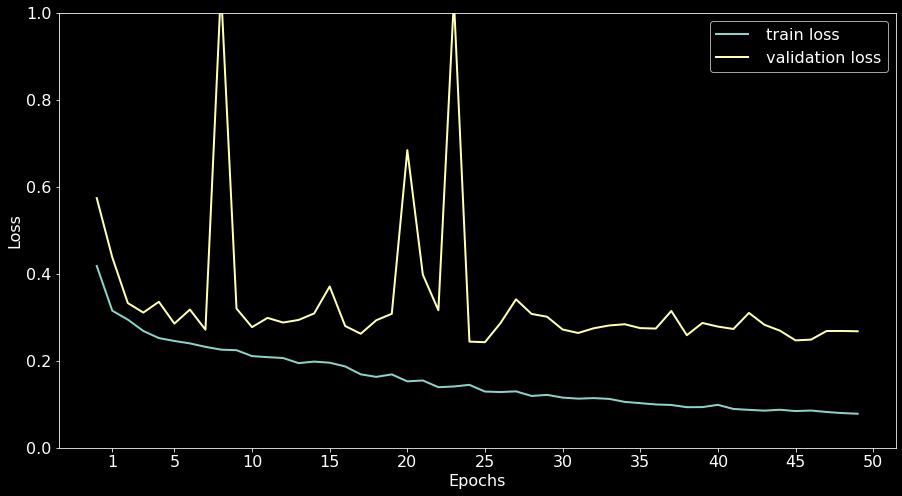


50


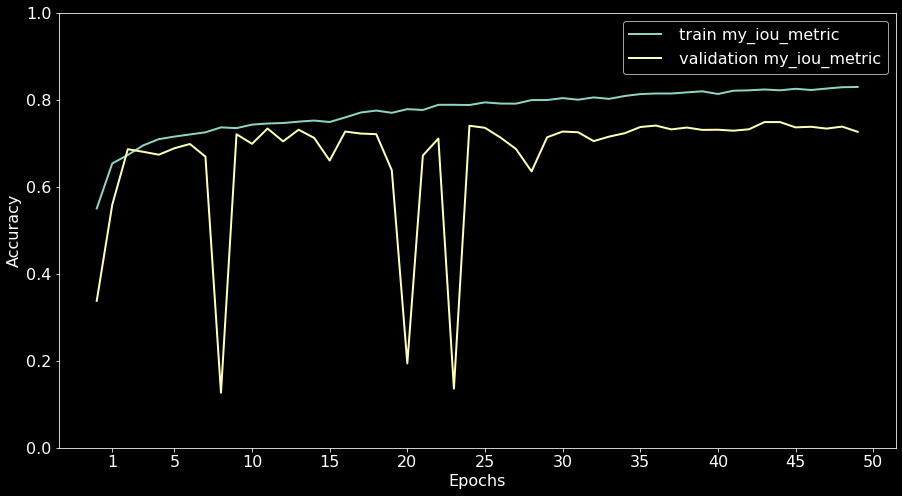

In [23]:
plot_history(hs={'': history}, epochs=epochs, metric='loss')
plot_history(hs={'': history}, epochs=epochs, metric='my_iou_metric')

### Saving the results to txt files

In [ ]:
loss_history = np.array(history.history["loss"]).reshape((50, 1))
IoU_history = (np.array(history.history["my_iou_metric"])).reshape((50 , 1))
val_loss_history = np.array(history.history["val_loss"]).reshape((50 , 1))
val_IoU_history = (np.array(history.history["val_my_iou_metric"])).reshape((50 , 1))

np.savetxt(model_save_dir+"/logs/IoU.txt", 
           IoU_history, delimiter=",")
np.savetxt(model_save_dir+"/logs/Loss.txt", 
           loss_history, delimiter=",")
np.savetxt(model_save_dir+"/logs/val_IoU.txt", 
           val_IoU_history, delimiter=",")
np.savetxt(model_save_dir+"/logs/val_Loss.txt", 
           val_loss_history, delimiter=",")

### Evaluating the best model

In [22]:
best_model = keras.models.load_model("./Test_1_checkpoints\saved-45-0.75.hdf5", 
                                    custom_objects={"my_iou_metric": my_iou_metric, "bce_dice_loss": bce_dice_loss}, compile=True)

In [23]:
best_model.compile(optimizer=adam_optimizer, loss=bce_dice_loss, metrics=[my_iou_metric])

In [24]:
best_model.evaluate(x=x_test, y=y_test, batch_size=1)

500/500 [==============================] - 22s 34ms/step - loss: 0.5885 - my_iou_metric: 0.7546


[0.5752320885658264, 0.7489995360374451]

### Cleaning up

In [25]:
K.clear_session()
gc.collect()
del backbone
del model
del best_model
del train_df
del x_train
del x_test
del x_valid
del y_train
del y_test
del y_valid
gc.collect()

31290